## Evaluation Metrics for Classification Models

### 1. Classification model

Let's begin by repeating the preprocessing and modeling we did in notebook 2:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

Loading the data:

In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Preprocessing:

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for column in categorical_columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')

df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'] = df['totalcharges'].fillna(0)

df['churn'] = (df['churn'] == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical_features = ['tenure', 'monthlycharges', 'totalcharges']

categorical_features = ['gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity','onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract',
    'paperlessbilling', 'paymentmethod']

Modeling:

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = y_pred >= 0.5
(y_val == churn_decision).mean()

0.8034066713981547

### 2. Accuracy and dummy model

Now we are going to answer the question: is 80% score good enough for this model?

#### 2.1 Evaluate the model on different threshols

Due to the fact that we assigned a threshold (`0.5`) to decide if our prediction is `1` or `0`, we obtainded a certain number of churning customers, but this can change if we choose a different treshold. Let's inspect that: 

In [8]:
thresholds = np.linspace(0, 1, 21)
scores = []

for threshold in thresholds:
    churn_decision = y_pred >= threshold
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (threshold, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


Let's plot these results:

Text(0, 0.5, 'score')

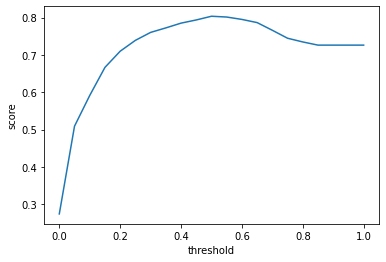

In [9]:
plt.plot(thresholds, scores)
plt.xlabel('threshold')
plt.ylabel('score')

This curve show us that there is a maximum score for a given treshold value, which actually optimizes the model's performance for a particular traing dataset.

We have a specific funcion in `Scikit-Learn` to this process:

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
churn_decision = y_pred >= 0.5
accuracy_score(y_val, churn_decision)

0.8034066713981547

Let's repeat changeing our threshold value:

In [12]:
thresholds = np.linspace(0, 1, 21)
scores = []

for threshold in thresholds:
    churn_decision = y_pred >= threshold
    score = accuracy_score(y_val, churn_decision)
    print('%.2f %.3f' % (threshold, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


#### 2.2 Checking the accuracy for dummy baselines

There are a couple of situations that may have our attention. One of them is when we set our threshold to `1`, which means that we're saying that none of the custormes will churn.

If we say that, we'll obtain an accuracy of `72.6%`. This means that __accuracy__ is not a good performance's measure for our classification model. 

### 3. Confusion table

#### 3.1 Different type of errors and correct decisions

When we predict a classification using a threshold, we're going to have these situations:

- The __True Positives__ and __True Negatives__
- The __False Positives__ and __False Negatives__

In [13]:
actaul_positive = (y_val == 1)
actaul_negative = (y_val == 0)

In [14]:
threshold = 0.5

predicted_positive = (y_pred >= threshold)
predicted_negative = (y_pred < threshold)

Let's combine the above groups of data:

In [15]:
true_positives = (predicted_positive & actaul_positive).sum()
true_negatives = (predicted_negative & actaul_negative).sum()

In [16]:
(true_positives, true_negatives)

(210, 922)

In [17]:
false_positives = (predicted_positive & actaul_negative).sum()
false_negatives = (predicted_negative & actaul_positive).sum()

In [18]:
(false_positives, false_negatives)

(101, 176)

#### 3.2 Arranging errors in a table

We can manually build a confusion matrix with these data:

In [19]:
confusion_matrix = np.array([
    [true_negatives, false_positives],
    [false_negatives, true_positives]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

Let's put it in relative values:

In [20]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

Now we can see that our initial accuracy of `80%` comes from the sum of the `ture_negatives + true_positives`:

`accuracy = 80% = 65% + 15%`

Or, we could say that:

`accuracy = (tp + tn)` $\div$ `(tp + tn + fp + fn)`

### 4. Precision and Recall

#### 4.1 Precision

Precision: how many positive predictions are correct? Or, the fraction of positivie predictions that are correct.

$
precision = \frac{true \space positives}{total \space predicted \space positive} \space \rightarrow \space \frac{true \space positives}{true \space positives + false \space positives}
$ 

In [21]:
precision = true_positives / (true_positives + false_positives)
precision

0.6752411575562701

#### 4.2 Recall

Recall: fraction of positive examples correctly identified. So we're now comapring against the actual positive values.

$
recall = \frac{true \space positives}{atual \space positives} \space \rightarrow \space \frac{true \space positives}{true \space positives + false \space negatives}
$

In [22]:
recall = true_positives / (true_positives + false_negatives)
recall

0.5440414507772021

### 5. ROC Curves

#### 5.1 TPR and FRP

In order to build an ROC curve, we're going to be interested in two values:

- FPR (false positivies rate) = FP $\div$ (TN + FP)
- TPR (true positives rate) = TP $\div$ (FN + TP)

What we're looking for it to minimize FPR and maximize the TPR.

In [23]:
fpr = false_positives / (true_negatives + false_positives)
fpr

0.09872922776148582

In [24]:
tpr = true_positives / (false_negatives + true_positives)
tpr

0.5440414507772021

Notice that TPR is the same as Recall

For a ROC curve, there is an evaluation of FPR and TPR for all the possible thresholds. Let's do that:

In [25]:
thresholds = np.linspace(0, 1, 101)
scores = []

for threshold in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (y_pred >= threshold)
    predicted_negative = (y_pred < threshold)

    tp = (predicted_positive & actaul_positive).sum()
    tn = (predicted_negative & actaul_negative).sum()

    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actaul_positive).sum()

    scores.append((threshold, tp, fp, fn, tn))

Putting the results into a data frame:

In [26]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [27]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


Let's add the TPR and FPR to the data frame:

In [28]:
df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'])

Text(0, 0.5, 'Rate')

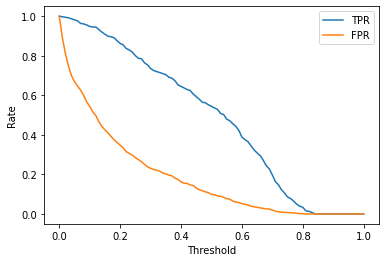

In [29]:
plt.plot(df_scores['threshold'], df_scores['tpr'], label='TPR')
plt.plot(df_scores['threshold'], df_scores['fpr'], label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')

#### 5.2 Random model

We will create a random set of churning customers:

In [30]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [31]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

Let's create a data frame again, this time using the `y_rand` values. We'll wrap up what we did so fat to build the data frame in a function:

In [32]:
def tpr_fpr_dataframe(y_val, y_pred):    
    thresholds = np.linspace(0, 1, 101)
    scores = []

    for threshold in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predicted_positive = (y_pred >= threshold)
        predicted_negative = (y_pred < threshold)

        tp = (predicted_positive & actaul_positive).sum()
        tn = (predicted_negative & actaul_negative).sum()

        fp = (predicted_positive & actual_negative).sum()
        fn = (predicted_negative & actaul_positive).sum()

        scores.append((threshold, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
    df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'])

    return df_scores

Testing the function:

In [33]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


Plotting the random values:

Text(0, 0.5, 'Rate')

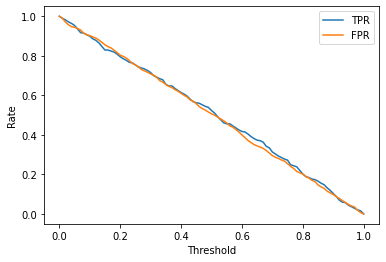

In [34]:
plt.plot(df_rand['threshold'], df_rand['tpr'], label='TPR')
plt.plot(df_rand['threshold'], df_rand['fpr'], label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')

What we see for this model is that, due to the fact that we are using a uniform distribution (like fliping a coin) we have 50-50 chances to have a churning or a not churning customer, so that is what the curve is showing us.

#### 5.3 Ideal model

For this case, we are going to consider an ideal churning model. Let's imagine a set of predictions and we order that from the smallest to highest probability. The first values would be the not-churning customers and the last ones would be the churning ones.

In [35]:
negative_samples = (y_val == 0).sum()
positive_samples = (y_val == 1).sum()
negative_samples, positive_samples

(1023, 386)

In [36]:
y_ideal = np.repeat([0, 1], [negative_samples, positive_samples])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [37]:
len(y_ideal)

1409

This would act as our validation set that we can use to benchmark our model. Let's now calculate our predictions:

In [38]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [39]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [40]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [41]:
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

Text(0, 0.5, 'Rate')

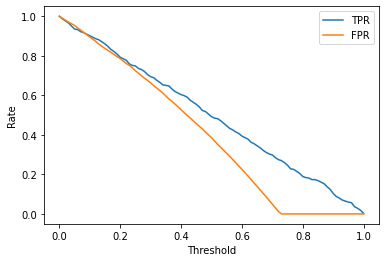

In [42]:
plt.plot(df_ideal['threshold'], df_ideal['tpr'], label='TPR')
plt.plot(df_ideal['threshold'], df_ideal['fpr'], label='FPR')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')

In [43]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,348,882,38,103,0.901554,0.895431
20,0.2,306,741,80,202,0.792746,0.785790
30,0.3,268,600,118,305,0.694301,0.662983
40,0.4,233,459,153,411,0.603627,0.527586
50,0.5,190,319,196,508,0.492228,0.385732
60,0.6,152,178,234,611,0.393782,0.225602
70,0.7,115,37,271,715,0.297927,0.049202
80,0.8,73,0,313,814,0.189119,0.000000
90,0.9,40,0,346,922,0.103627,0.000000


#### 5.4 Putting it all together

It's good to plot the ideal model and the actual model and see how far are the model curves from the ideal curves. Now let's compare the `false_positive_rate` against the  `true_positive_rate`:

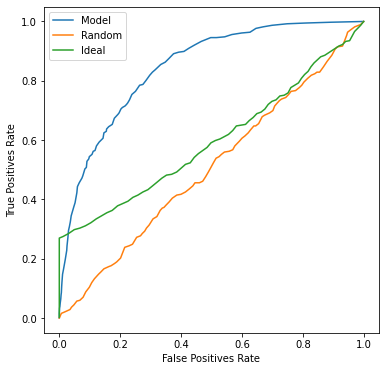

In [44]:
plt.figure(figsize=(6, 6))

plt.plot(df_scores['fpr'], df_scores['tpr'], label='Model')
plt.plot(df_rand['fpr'], df_rand['tpr'], label='Random')
plt.plot(df_ideal['fpr'], df_ideal['tpr'], label='Ideal')

plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.legend()

We can also acomplish this task using Scikit-Learn library:

In [45]:
from sklearn.metrics import roc_curve

In [46]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

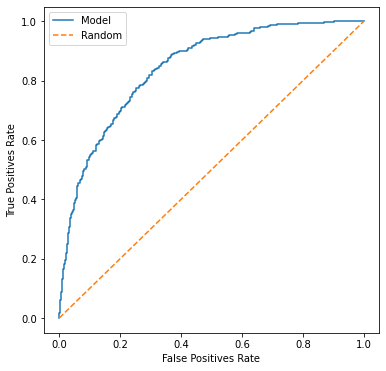

In [47]:
plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.legend()

As we see, this is a way of looking at our model's performance. It would be better if we can have a metric derived from the ROC curve, that is the AUC (Area Under the Curve).

### 6. ROC AUC

#### 6.1 Area under the ROC curve

Due to gemetrical facts of the ROC graphic, the AUC can only take values between `0.5` and `1.0` and the bigger de AUC the better our model performs.

Let's use Scikit-Learn to calculate this:

In [48]:
from sklearn.metrics import auc

From the result of the `roc_curve` method (more accurate):

In [49]:
auc(fpr, tpr)

0.8438479732980819

Or using our own data:

In [50]:
auc(df_scores['fpr'], df_scores['tpr'])

0.8438732975754537

We also have a shortcut to do this:

In [51]:
from sklearn.metrics import roc_auc_score

In [52]:
roc_auc_score(y_val, y_pred)

0.8438479732980819

#### 6.2 Interpretation of AUC

What the AUC is telling us is the probability that a randomly selected churning customer has a greater score than the one for a randomly selected not-churning customer.

In [53]:
import random

In [54]:
pos = y_pred[y_val == 1]
neg = y_pred[y_val == 0]

In [55]:
n = 100000
success = 0

for i in range(n):
    pos_idx = random.randint(0, len(pos) - 1)
    neg_idx = random.randint(0, len(neg) - 1)

    if pos[pos_idx] > neg[neg_idx]:
        success += 1

success / n

0.84505

We can do the same process with `numpy`:

In [56]:
n = 100000

np.random.seed(1)
pos_idx = np.random.randint(0, len(pos), size=n)
neg_idx = np.random.randint(0, len(neg), size=n)

(pos[pos_idx] > neg[neg_idx]).mean()

0.84288

We can see that our example give us a result pretty close to the one we obtainded by using the `roc_auc_score` function.

### 7. Cross-Validation

#### 7.1 Evaluating the same model on different subsets of data

The objective here is to split our dataset for example in three parts and train the model as follows:

- Part 1 and Part 2 for Training; Part 3 for validations and measuring the AUC1
- Part 1 and Part 3 for Training; Part 2 for validations and measuring the AUC2
- Part 2 and Part 3 for Training; Part 1 for validations and measuring the AUC3

At the end we compute the mean for AUC.

In [84]:
def train(df, y_train, C=1.0):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)

    return dv, model

In [60]:
def predict(df, dv, model):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')
    
    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [71]:
dv, model = train(df_train, y_train)

In [72]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.00899695, 0.20452528, 0.21222294, ..., 0.13638997, 0.7997649 ,
       0.83740282])

Importing the library to work with cross-validation and implementing it:

In [73]:
from sklearn.model_selection import KFold

In [76]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx)

(5070, 564)

Let's get our data frames from the splitted data:

In [78]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['churn'].values
    y_val = df_val['churn'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [83]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.841 +- 0.012


#### 7.2 Getting the average prediction and the spread within prediction

We can apply regularization by modifing the default value of `C` in the `train` function:

In [92]:
from tqdm.auto import tqdm

In [99]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['churn'].values
        y_val = df_val['churn'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 17%|█▋        | 1/6 [00:06<00:30,  6.18s/it]

C=0.001 0.826 +- 0.011


 33%|███▎      | 2/6 [00:12<00:24,  6.09s/it]

C=0.01 0.840 +- 0.009


 50%|█████     | 3/6 [00:17<00:16,  5.54s/it]

C=0.1 0.840 +- 0.008


 67%|██████▋   | 4/6 [00:21<00:10,  5.18s/it]

C=1 0.839 +- 0.007


 83%|████████▎ | 5/6 [00:26<00:05,  5.09s/it]

C=5 0.840 +- 0.007


100%|██████████| 6/6 [00:31<00:00,  5.22s/it]

C=10 0.840 +- 0.008


With these results we can use the default value `C=1.0`

In [100]:
dv, model = train(df_full_train, df_full_train['churn'].values)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259